In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm, animation
from IPython.display import HTML
from tqdm import tqdm_notebook

## 1. SN Class

model - 

$$ y = \frac{1}{1+exp^{-(wx + b)}} \space [where\space y = 0,1]$$

In [ ]:
# training data
X = np.array([0.5,2.5])
Y = np.array([0.2,0.9])

In [ ]:
class SN:
  
  def __init__(self,w_int,b_int):
    self.w = w_int
    self.b = b_int
    self.w_h = []  # histories for weights
    self.b_h = []  # histories for bias term
    self.error_h = [] # histories for errors
    
  def sigmoid(self,x):
    return 1/(1+np.exp(-x))
  
  def model(self, x,w=None,b=None):
    if w is None and b is None:
      w = self.w
      b = self.b
      
    return self.sigmoid(self.w*x+self.b)

  def grad_w(self,x,y,w=None,b=None):
    if w is None and b is None:
      w = self.w
      b = self.b
    y_pred = self.model(x,w,b)
    return (y_pred-y)*(y_pred)*(1-y_pred)*x
    
  def grad_b(self,x,y,w=None,b=None):
    if w is None and b is None:
      w = self.w
      b = self.b
    y_pred = self.model(x,w,b)
    return (y_pred-y)*(y_pred)*(1-y_pred)
  
  def error(self,X=None,Y=None,W=None,B=None):
    if X is None:
      X = self.X
    
    if Y is None:
      Y = self.Y
      
    if W is None:
      W = self.w
    
    if B is None:
      B = self.b
    
    err = 0
    m = len(self.X)
    for x,y in zip(self.X,self.Y):
      model = 1/(1+np.exp(-(W*x+B)))
      err += np.square((model-y))
    return err/m

  def fit(self,X,Y,epochs=1,learning_rate=1,display_loss=True,algorithm ='GD',gamma=0.8,batch_size=32,beta=1,eps=1e-8,beta1=0.2,beta2=0.5):
    m = len(X)
    self.X, self.Y = X,Y
    
    if algorithm == 'GD':
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0
        
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)

        self.w -= learning_rate*dw/m
        self.b -= learning_rate*db/m
        self.append_log()


    elif algorithm == 'Momentum':
      
      # parameters for momemtum
      vt_w = 0
      vt_b = 0
      
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0

        for x,y in zip(X,Y): 
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)

        vt_w = gamma*vt_w + learning_rate*dw/m
        vt_b = gamma*vt_b + learning_rate*db/m
        self.w -= vt_w
        self.b -= vt_b
        self.append_log()

    elif algorithm == 'NAG':  # Nestorov Accelerated Gradeint Descent
      
      # parameters for NAG
      vt_w = 0
      vt_b = 0
      
      w_temp = self.w - gamma*vt_w
      b_temp = self.w - gamma*vt_b
      
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0
        for x,y in zip(X,Y): 
          # derivative of w_temp
          dw += self.grad_w(x,y,w=w_temp,b=b_temp)
          db += self.grad_b(x,y,w=w_temp,b=b_temp)

        vt_w = gamma*vt_w + learning_rate*dw/m
        vt_b = gamma*vt_b + learning_rate*db/m

        w_temp = self.w - gamma*vt_w
        b_temp = self.b - gamma*vt_b

        self.w = self.w - vt_w
        self.b = self.b - vt_b

        self.append_log()

    elif algorithm == 'MiniBatch':
      
      # parameters for mini-batch
      count = 0
      
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0

        count += 1
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          if count % batch_size == 0:
            self.w -= learning_rate*dw/batch_size
            self.b -= learning_rate*db/batch_size
            self.append_log()
            dw, db = 0,0
            
            
    elif algorithm == 'Adagrad':
      v_w = 0
      v_b = 0
      
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          
        v_w += dw**2
        v_b += db**2
        
        self.w -= (learning_rate*dw)/(np.sqrt(v_w)+eps)
        self.b -= (learning_rate*db)/(np.sqrt(v_b)+eps)
        self.append_log()
        
        
    elif algorithm == 'RMSProp':
      v_w = 0
      v_b = 0
      
      for i in tqdm_notebook(range(epochs),unit='Epoch',total=epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          
        v_w = beta*v_w + (1-beta)*dw**2
        v_b = beta*v_b + (1-beta)*db**2
        
        self.w -= (learning_rate*dw)/(np.sqrt(v_w)+eps)
        self.b -= (learning_rate*db)/(np.sqrt(v_b)+eps)
        self.append_log()
        
    elif algorithm == 'Adam':
      v_w, v_b = 0, 0
      m_w, m_b = 0, 0
      num_updates = 0
      for i in range(epochs):
        dw, db = 0, 0
        num_updates += 1
        for x, y in zip(X, Y):
          dw = self.grad_w(x, y)
          db = self.grad_b(x, y)
          
        m_w = beta1 * m_w + (1-beta1) * dw
        m_b = beta1 * m_b + (1-beta1) * db
        v_w = beta2 * v_w + (1-beta2) * dw**2
        v_b = beta2 * v_b + (1-beta2) * db**2
        m_w_c = m_w / (1 - np.power(beta1, num_updates))
        m_b_c = m_b / (1 - np.power(beta1, num_updates))
        v_w_c = v_w / (1 - np.power(beta2, num_updates))
        v_b_c = v_b / (1 - np.power(beta2, num_updates))
        self.w -= learning_rate / (np.sqrt(v_w_c) + eps) * m_w_c
        self.b -= learning_rate / (np.sqrt(v_b_c) + eps) * m_b_c
        self.append_log()
        
    if display_loss:
      plt.plot(range(len(self.error_h)),self.error_h)
      plt.show()
   
    
  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.error_h.append(self.error())

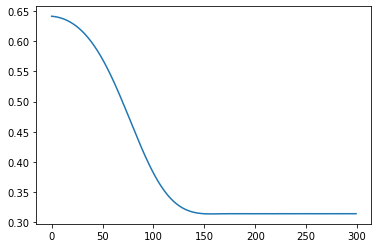

In [ ]:
epochs = 300
x_int,y_int = -3,4
sn = SN(x_int,y_int)
sn.fit(X,Y,epochs=epochs,learning_rate=0.01,display_loss=True,algorithm='Adam',gamma=0.8,batch_size = 1,beta=0.5,eps=1e-8,beta1=0.3,beta2=0.4)

In [ ]:
algorithms = ['GD','Momentum','NAG','MiniBatch','Adagrad','RMSProp']
models = []
for algorithm in algorithms:
  sn = SN(x_int,y_int)
  sn.fit(X,Y,epochs=epochs,learning_rate=1,display_loss=False,algorithm=algorithm,gamma=0.8,batch_size = 1,beta=0.5,eps=1e-8,beta1=0.9,beta2=0.2)
  models.append(sn)

## 2. Plotting 2D contour Plot

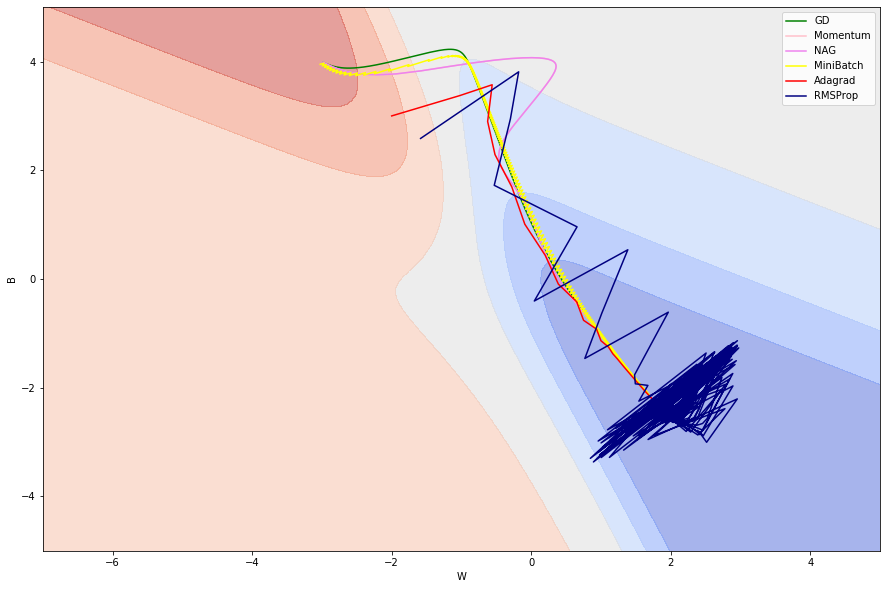

In [ ]:
my_cmap = LinearSegmentedColormap.from_list("",['red','white','blue'])
colors = ['green','pink','violet','yellow','red','navy']
w_min = -7
w_max = 5

b_min = -5
b_max = 5

x1 = np.linspace(w_min,w_max,100)
x2 = np.linspace(b_min,b_max,100)

plt.figure(figsize=(15,10))
WW,BB = np.meshgrid(x1,x2)
error = sn.error(X,Y,W=WW,B=BB)
plt.axes(xlim=(w_min,w_max),ylim=(b_min,b_max))

plt.contourf(WW,BB,error,cmap=cm.coolwarm,alpha=0.5)
for sn,algo,color in zip(models,algorithms,colors):
  plt.plot(sn.w_h,sn.b_h,label=algo,color=color)
   
#plt.plot(sn7.w_h,sn7.b_h,label='Adam')

plt.xlabel('W')
plt.ylabel('B')
plt.legend()
plt.show()

## 3. Plotting 3D contour plot

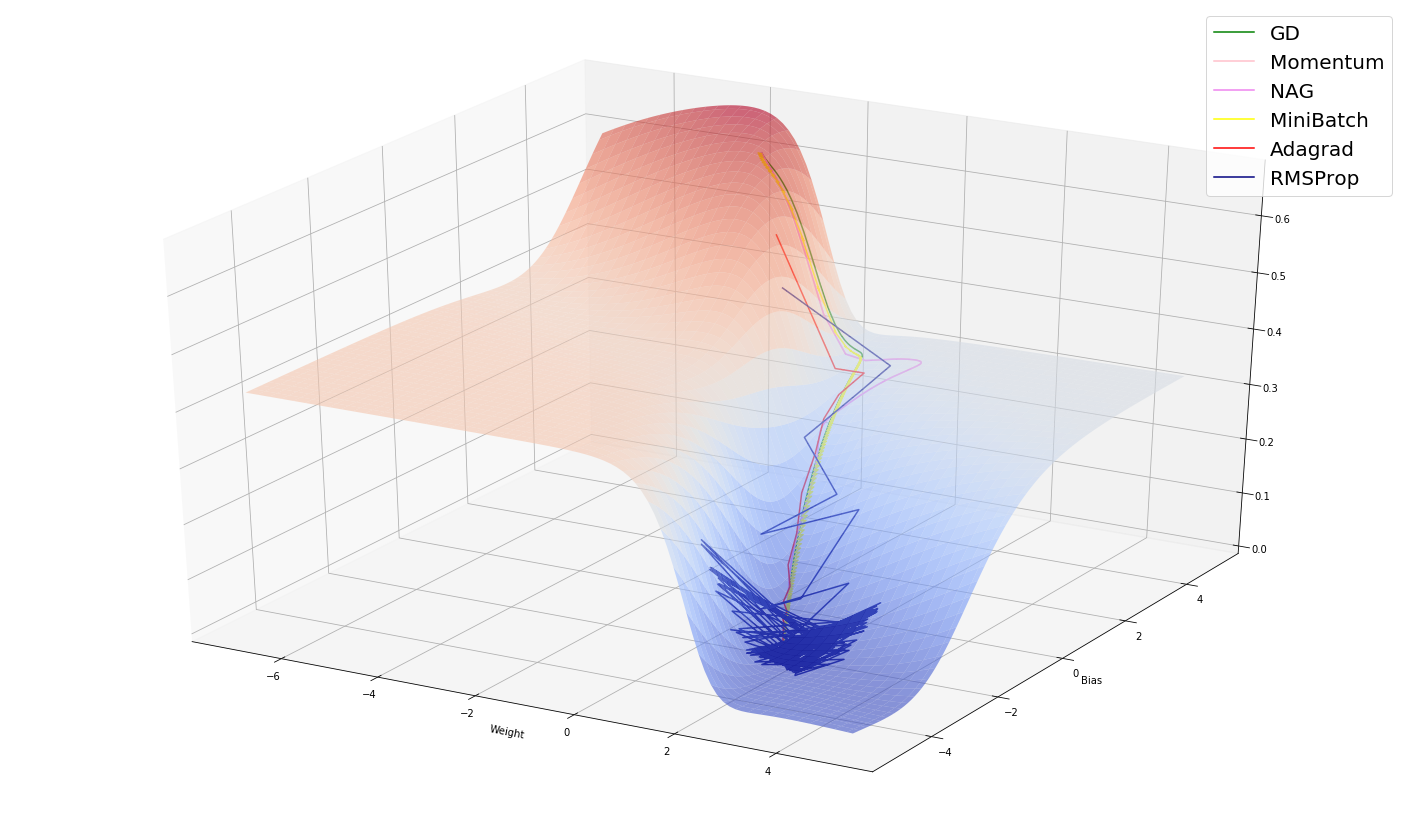

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(WW,BB,error,cmap=cm.coolwarm,alpha=0.6)
ax.set_xlabel('Weight')
ax.set_ylabel('Bias')
colors = ['green','pink','violet','yellow','red','navy']

# plot the learning rate
for sn,algo,color in zip(models,algorithms,colors):
  plt.plot(sn.w_h,sn.b_h,sn.error_h,label=algo,color=color)

plt.legend(fontsize=20)

## 4. Animation of plots

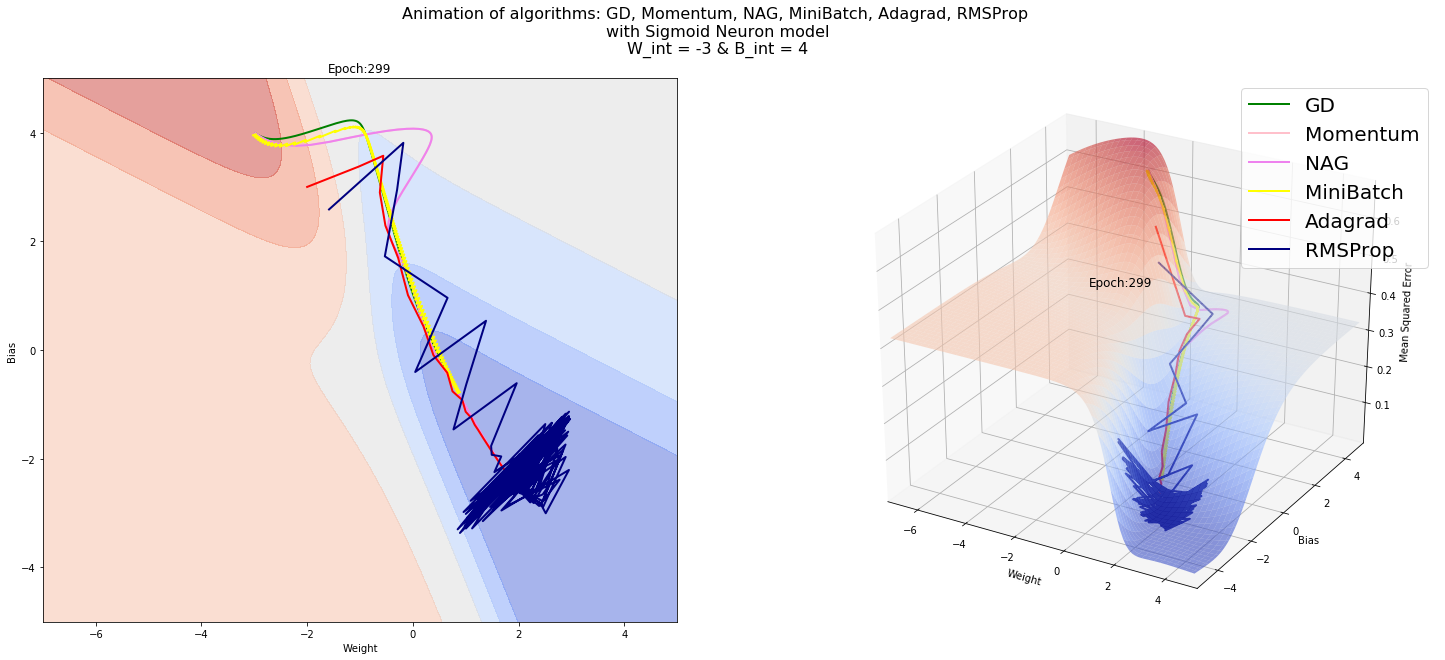

In [ ]:
%%time
frames,interval = epochs,100


fig = plt.figure(figsize=(25,10))
fig.suptitle('Animation of algorithms: GD, Momentum, NAG, MiniBatch, Adagrad, RMSProp \nwith Sigmoid Neuron model\nW_int = -3 & B_int = 4',fontsize=16)

ax1 = plt.subplot(121,xlim=(-7,5), ylim=(-5,5))
ax2 = plt.subplot(122,xlim=(-7,5), ylim=(-5,5),projection='3d')

ax1.contourf(WW,BB,error,cmap=cm.coolwarm,alpha=0.5)
ax1.set_xlabel('Weight')
ax1.set_ylabel('Bias')

ax2.plot_surface(WW,BB,error,cmap=cm.coolwarm,alpha=0.6)
ax2.set_xlabel('Weight')
ax2.set_ylabel('Bias')
ax2.set_zlabel('Mean Squared Error')

def setup_lines(n,axes):
  lines = [] 
  titles = []
  for algo,color in zip(algorithms,colors):
    line, = axes.plot([],[],lw=2,label=algo,color=color) 
    title = axes.set_title('Epoch: ')
    lines.append(line)
    titles.append(title)
  return lines,titles

lines,titles = setup_lines(n=6,axes=ax1)  # lines for 2D plot
lines_3d,titles_3d = setup_lines(n=6,axes=ax2) # lines for 3D plot
plt.legend(lines_3d,algorithms,fontsize=20)

def animate_lines(i,lines=lines,title=titles):
 
  
  for line,title,sn in zip(lines,titles,models):
    weights = np.array(sn.w_h)
    biases = np.array(sn.b_h)
    errors = np.array(sn.error_h)
    
    x = weights[0:i+1]
    y = biases[0:i+1]
    z = errors[0:i+1]
    
    line.set_data(x,y)
    title.set_text('Epoch:'+str(i))
    
  for line_3d,title_3d,sn in zip(lines_3d,titles_3d,models):
    
    weights = np.array(sn.w_h)
    biases = np.array(sn.b_h)
    errors = np.array(sn.error_h)
    
    x = weights[0:i+1]
    y = biases[0:i+1]
    z = errors[0:i+1]
    
    line_3d.set_data(x,y)
    line_3d.set_3d_properties(z)
    title_3d.set_text('Epoch:'+str(i))
  
  return lines

anim = animation.FuncAnimation(fig, animate_lines,frames=frames, interval=interval, blit=True)
anim.save('algo_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
HTML(anim.to_html5_video())

## 5. Further Study


link - 
http://ruder.io/optimizing-gradient-descent/index.html#visualizationofalgorithms